In [1]:
import json
import requests

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error

Using TensorFlow backend.


In [2]:
sns.set_palette('Set2')
%matplotlib inline

# Get data

#### The data of Bitcoin/USD, we use joint URL in order to analyze the effect Ethereum later.

In [15]:
# API of Cryptographic currency in json format
url = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(url + '?fsym=BTC&tsym=USD&limit=2000')
# AUD train model时，会出现loss = NAN的情况。但是不知道为什么
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
hist.head()

,close,high,low,open,volumefrom,volumeto
time,,,,,,
2013-05-15,114.22,116.44,103.02,111.40,117967.89,13006447.75
2013-05-16,118.21,118.97,112.10,114.22,45232.06,5222066.01
2013-05-17,123.50,125.56,116.57,118.21,79123.93,9608029.60
2013-05-18,123.21,125.31,122.25,123.50,22652.03,2804847.39
2013-05-19,122.50,124.50,119.50,123.21,20571.91,2507881.36


In [208]:
hist.tail(1)

,close,high,low,open,volumefrom,volumeto
time,,,,,,
2018-11-05,6436.06,6475.8,6420.85,6467.05,8805.02,56900407.28


#### Now set close price as target data, and later we will add price gap into model

In [209]:
target_col = 'close'

# Split training and test dataset

80% is used for training, 20% is used for testing.

In [294]:
def train_test_split(df, test_size=0.5):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

# Data Visulization

#### Have to consider that training data is all in lower price, but testing data is all in higher price, so it might be errors. 

# Build LSTM Model

#### Normalization

As the model does not ought to predict future price, but future change percentage.

必须小心谨慎哪部分数据在什么时候应该被缩放。一个**常见的错误是在训练集和测试集拆分应用之前缩放整个数据集**。为什么这是一个错误？由于缩放调用统计量，例如变量的最小/最大值。在现实生活中执行时间序列预测时，在预测时没有来自未来观测的信息。因此，**必须对训练数据进行比例统计计算，然后将其应用于测试数据**。否则，在预测时使用未来信息，这往往会使预测指标偏向正向。

In [295]:
def normalise_zero_base(df):
    """ Normalise dataframe column-wise to reflect changes with respect to first entry. """
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    """ Normalise dataframe column-wise min/max. """
    return (df - df.min()) / (data.max() - df.min())

#### shift data for average-7-days

In [296]:
# 多创建出了feature，对每个维度都多创建出了window len那么多的新feature
# （sample, dimension） -> (sample, new feature window length, dimension)
# 结果是即使LSTM有长短记忆的功能，窗口短的要比窗口长的，模型结果要准确
# window_len和之后的prediction length是没有直接关系的，相互独立
def extract_window_data(df, window_len=7, zero_base=True):
    """ Convert dataframe to overlapping sequences/windows of len `window_data`.
    
        :param window_len: Size of window
        :param zero_base: If True, the data in each window is normalised to reflect changes
            with respect to the first entry in the window (which is then always 0)
    """
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [297]:
def prepare_data(df, target_col, window_len=7, zero_base=True, test_size=0.2):
    """ Prepare data for LSTM. """
    # train test split
    train_data, test_data = train_test_split(df, test_size=test_size)
    
    # extract window data
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    
    # extract targets
    # 把7天之后的price当作需要拟合/预测的价格
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

#### 1 layer LSTM model

In [298]:
def build_lstm_model(input_data, output_size, neurons=20, activ_func='linear',
                     dropout=0.25, loss='mae', optimizer='adam'):
    model = Sequential()
    print('input_data.shape'+str(input_data.shape))
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [299]:
np.random.seed(42)

# data params
window_len = 7
test_size = 0.1
zero_base = True

# model params
lstm_neurons = 20
epochs = 50
batch_size = 4
loss = 'mae'
dropout = 0.25
optimizer = 'adam'

In [300]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [301]:
X_train.shape

(1794, 7, 6)

In [302]:
from keras.callbacks import EarlyStopping

# patience=2: 两次loss连续上升就会停止
early_stopping = EarlyStopping(monitor='loss', patience=2)

model = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss, optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                    verbose=1, shuffle=True,callbacks=[early_stopping])

input_data.shape(1794, 7, 6)
Epoch 1/50
1794/1794 [==============================] - 5s 3ms/step - loss: 0.0749
Epoch 2/50
1794/1794 [==============================] - 4s 2ms/step - loss: 0.0535
Epoch 3/50
1794/1794 [==============================] - 4s 2ms/step - loss: 0.0466
Epoch 4/50
1794/1794 [==============================] - 5s 3ms/step - loss: 0.0431
Epoch 5/50
1794/1794 [==============================] - 4s 2ms/step - loss: 0.0425
Epoch 6/50
1794/1794 [==============================] - 4s 2ms/step - loss: 0.0399
Epoch 7/50
1794/1794 [==============================] - 4s 2ms/step - loss: 0.0386
Epoch 8/50
1794/1794 [==============================] - 4s 2ms/step - loss: 0.0386


# Prediction

In [303]:
preds = model.predict(X_test)
preds[:5]

array([[ 0.03345463],
       [ 0.01297772],
       [ 0.04293503],
       [ 0.04419206],
       [-0.03772087]], dtype=float32)

In [304]:
preds = model.predict(X_test).squeeze()
preds[:5]

array([ 0.03345463,  0.01297772,  0.04293503,  0.04419206, -0.03772087],
      dtype=float32)

In [305]:
targets = test[target_col][window_len:]
targets.shape

(193,)

In [306]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds.shape

(193,)

In [307]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(16, 9))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [AUD]', fontsize=14)
    ax.set_title(title, fontsize=18)
    ax.legend(loc='best', fontsize=18);

mse=7054.501251500184


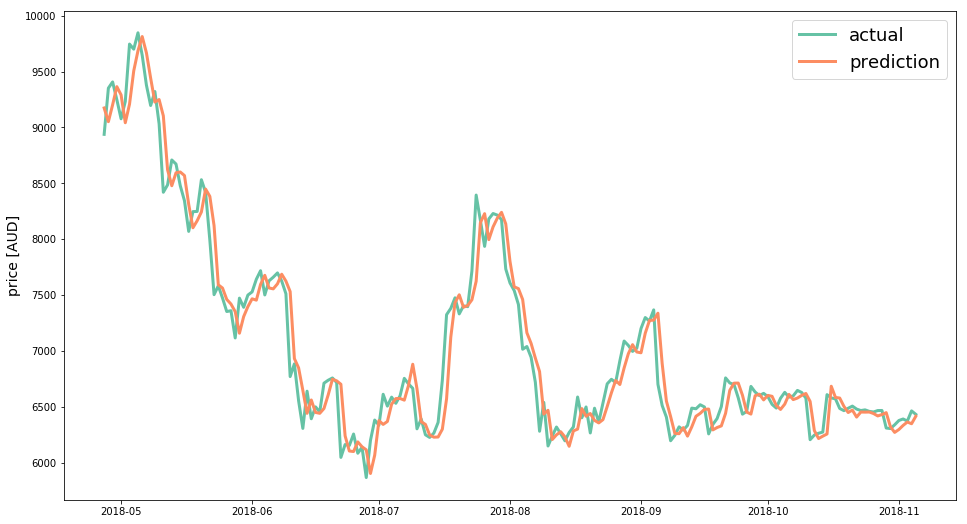

In [308]:
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

### 没有做到预测time sequence，只是数据平移

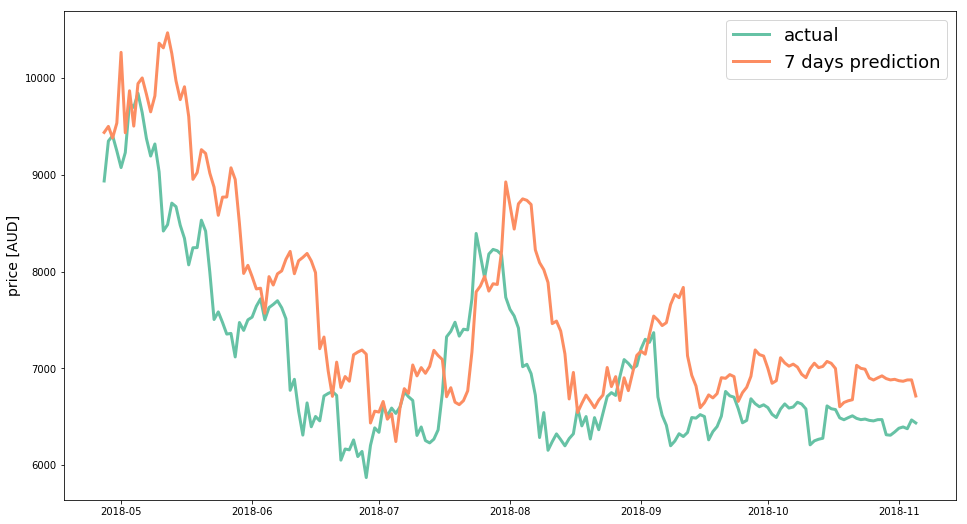

In [309]:
preds7 = model.predict(X_test).squeeze()

# 这么写是毫无根据的，凭空将预测的变化比率往后推7天没有实际意义。
preds7 = test[target_col].values[:-window_len] * (preds7[7] + 1)
preds7 = pd.Series(index=targets.index, data=preds7)

line_plot(targets, preds7, 'actual', '7 days prediction', lw=3)

### From 2018-06-18

### 14 days
##### 这是个假的操作，因为并不是基于datetime(year=2018, month=6, day=18)之前90天进行训练的

In [314]:
# truncate: 删掉之前的
from datetime import datetime,timedelta
import pandas as pd
time_begin = datetime(year=2018, month=6, day=18) - timedelta(days=90)
time_after = datetime(year=2018, month=6, day=18) + timedelta(days=14)

datetime.datetime(2018, 3, 20, 0, 0)

In [338]:
time = datetime(year=2018, month=6, day=18)
preds0618_14 = preds14.truncate(before = time)
preds0618_14 = preds0618_14.truncate(after = time_after)
preds0618_14.columns=['close']

In [330]:
y_test = targets.truncate(before = time_begin)
y_test = y_test.truncate(after = time_after)
y_test = y_test[:104]

In [339]:
a = pd.concat([y_test,preds0618_14],axis=1)
a.columns = ['y_test','preds0618_14']

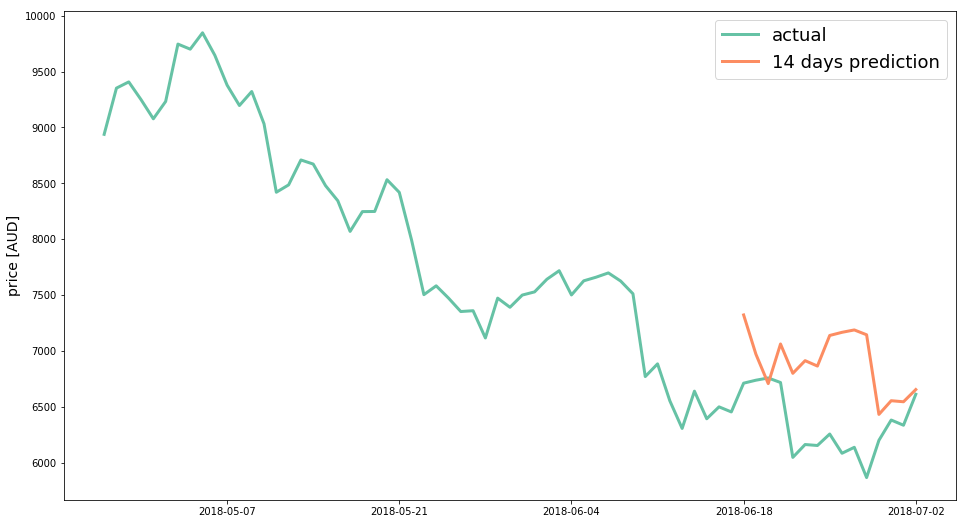

In [334]:
line_plot(y_test, preds0618_14, 'actual', '14 days prediction', lw=3)

In [335]:
a.to_csv('test.csv')

In [337]:
import math
preds0618_14_mse = preds0618_14
y_test_mse = y_test.truncate(before = time)
mse = mean_absolute_error(preds0618_14_mse, y_test_mse)
rmse = math.sqrt(mse)
print(rmse)

23.64976326171539


### Shift one day to further analyzed.

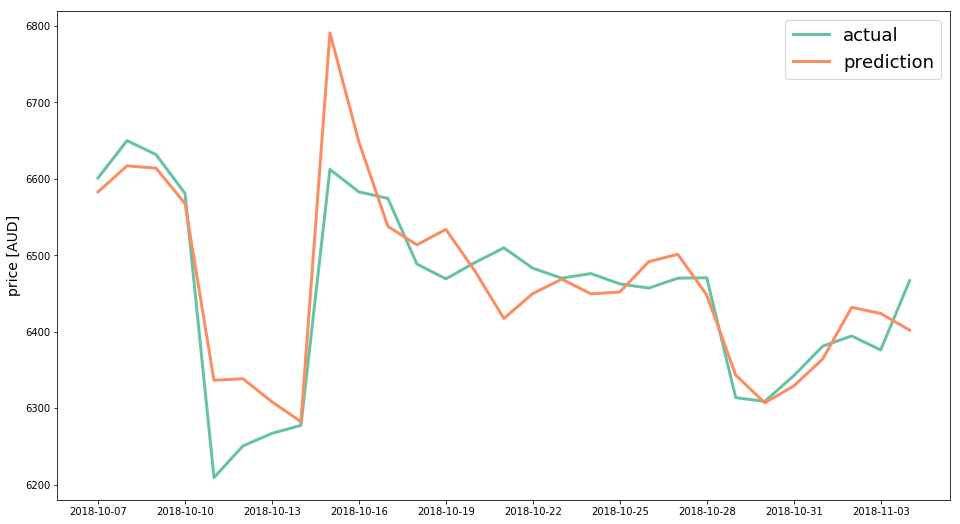

In [59]:
n_points = 30
line_plot(targets[-n_points:][:-1], preds[-n_points:].shift(-1), 'actual', 'prediction', lw=3)

### Correlation test

In [356]:
actual_returns = targets.pct_change()
actual_returns.head()
# 第一个没有变化率，当然是NaN啦

time
2018-04-27         NaN
2018-04-28    0.046205
2018-04-29    0.005942
2018-04-30   -0.016859
2018-05-01   -0.018508
Name: close, dtype: float64

In [351]:
# pct_change(): Percentage change between the current and a prior element
actual_returns = targets.pct_change()[1:]
predicted_returns = preds.pct_change()[1:]
print(actual_returns.shape)
# actual correlation
corr = np.corrcoef(actual_returns, predicted_returns)
corr

(192,)


array([[1.        , 0.05394178],
       [0.05394178, 1.        ]])

In [352]:
corr[0][1]

0.0539417810678564

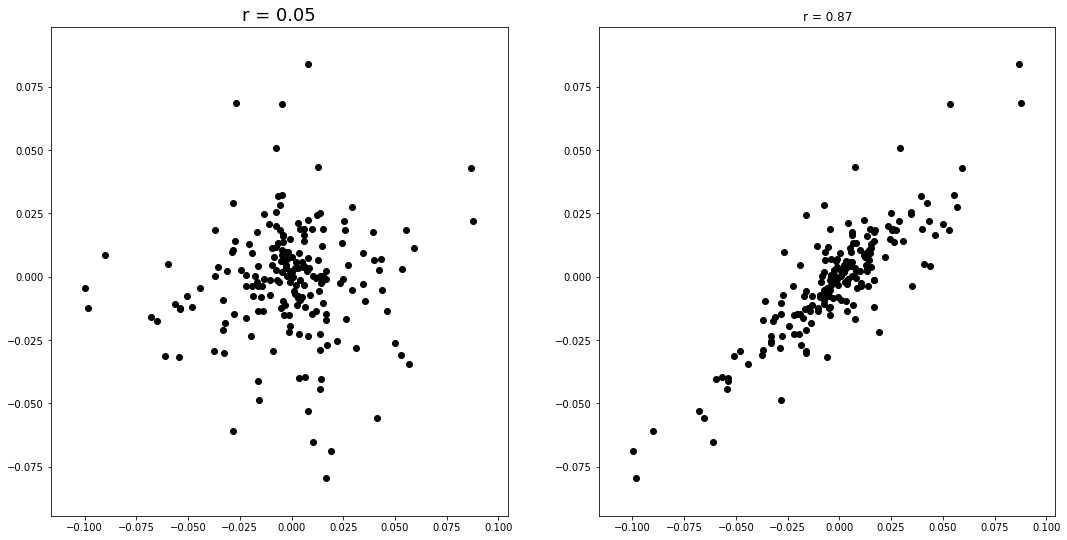

In [353]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))
corr = np.corrcoef(actual_returns, predicted_returns)[0][1]
ax1.scatter(actual_returns, predicted_returns, color='k')
ax1.set_title('r = {:.2f}'.format(corr), fontsize=18)
# shifted correlation
shifted_actual = actual_returns[:-1]
shifted_predicted = predicted_returns.shift(-1).dropna()
corr = np.corrcoef(shifted_actual, shifted_predicted)[0][1]
ax2.scatter(shifted_actual, shifted_predicted, color='k')
ax2.set_title('r = {:.2f}'.format(corr));

After predicted price is shifted one day back, the correlation is 0.98, almost 1, which means the prediced price is the same as previous day actual price.

In conclusion, this basic model is not practical at all.

## 以上，是keras自带的predict进行单点预测，接下来是一段时间的价格预测

good documentation 
http://www.jakob-aungiers.com/articles/a/LSTM-Neural-Network-for-Time-Series-Prediction

In [69]:
# window_size 只在这里出现过，而且实验证明只能取1
# prediction_len 建立新的feature
def predict_sequences_multiple(model, data, window_size, prediction_len):
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            # 这一行是在干嘛。。？？新加一个维度
            predicted.append(model.predict(curr_frame[np.newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            # 必须是1，不然：list index out of range
            # 不懂为啥是1
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

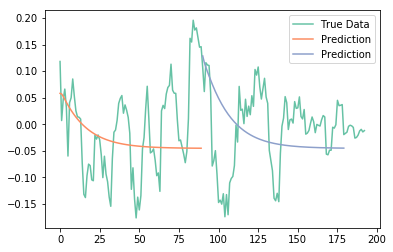

In [70]:
predictions = predict_sequences_multiple(model, X_test, 7, 90)
plot_results_multiple(predictions, y_test, 90)

# Reference

Tensorflow to perdict Stock price: https://vimsky.com/article/3847.html

Tensorflow 相比于高级AIP keras要更加灵活。